In [1]:
import pandas as pd
from pandas_datareader import data as web
import datetime

start = datetime.datetime(2000,1,1)
end = datetime.date.today()

# Let's get some stock data; for example, Apple's ticker symbol is AAPL
Symbol = 'AAPL'
Symbol = '^DJI'
#Symbol = 'MSFT'

# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
data = web.DataReader(Symbol, "yahoo", start, end)

#data.head()
data.tail()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-12-30,19833.169922,19852.550781,19718.669922,19762.599609,271910000,19762.599609
2017-01-03,19872.859375,19938.529297,19775.929688,19881.759766,339180000,19881.759766
2017-01-04,19890.939453,19956.140625,19878.830078,19942.160156,280010000,19942.160156
2017-01-05,19924.560547,19948.599609,19811.119141,19899.289062,269920000,19899.289062
2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,277700000,19963.800781


In [2]:
type(data)

pandas.core.frame.DataFrame

In [3]:
Prices = pd.DataFrame({Symbol: data["Adj Close"]}) # use for yahoo data
#Prices = pd.DataFrame({Symbol: data["Close"]}) # use for google data

In [4]:
import mpld3; # enables zooming
from pylab import *
#print(style.available)
style.use('seaborn-white')

In [5]:
fig = figure(figsize=(12,8))
clf
ax = fig.add_subplot(1, 1, 1)
rc('xtick',labelsize=12);rc('ytick',labelsize=16);rc('legend',fontsize=12)
Prices.plot(ax=ax,grid = True,linewidth=1,color='green');yscale('log');
ylabel('Price',fontsize=18)
xlabel('Date',fontsize=18)
savefig("Images/"+Symbol+"Prices.pdf")
savefig("Images/"+Symbol+"Prices.eps")
mpld3.display(fig)

For Apple, it looks as though something drastic happened in 2000. If we look at all the log-returns we can see this stand-out data point even more clearly. (You can find out more about what happened [here](http://money.cnn.com/2000/09/29/markets/techwrap/).)

However, the big drop happened over a weekend, so if we only consider log-returns over daily steps we don't see it.

In [6]:
# (optionally) replace Prices with weekly (Friday) prices 
N = len(Prices.index)
tmp = []
for i in range(N):
    if Prices.index[i].weekday()==4:
        tmp.append(i)
WeeklyPrices = Prices.iloc[tmp,:]
#Prices = WeeklyPrices

In [7]:
import numpy as np
LogReturns = Prices.apply(lambda x: np.log(x)-np.log(x.shift(1)))
# use only returns that correspond to the smallest timestep (1 day, 1 week, etc)
t = Prices.index; dt = min(diff(t))
t = Prices.index;ind=find(diff(t)==dt);
LogReturns = LogReturns.iloc[ind,:] 
dt = int(dt/np.timedelta64(1, 'D')) # in days
# plot
fig = figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
rc('xtick',labelsize=12);rc('ytick',labelsize=12);rc('legend',fontsize=12)
LogReturns.plot(ax=ax,style='go',grid = True,linewidth=0.2,markersize=6,markeredgecolor='black',markeredgewidth=0.5,alpha=0.4,clip_on=False);
if dt==1:
    ylabel('Log Return (1 day)',fontsize=18)
else:
    ylabel('Log Return (%d days)'%dt,fontsize=18)
xlabel('Date',fontsize=18)
savefig("Images/"+Symbol+"LogReturns.pdf")
savefig("Images/"+Symbol+"LogReturns.eps")
mpld3.display(fig)

Let's create a histogram of the log-returns and compare with the best fit normal.

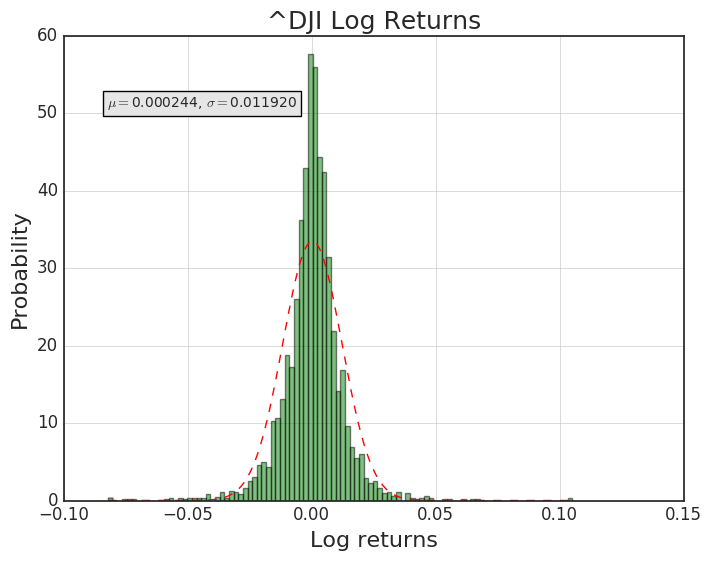

In [8]:
fig = figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
nbins = 100
x = LogReturns.values[1:]
x.shape = (len(x),) # make sure the dimensions of x are what the tests below expect
n,bins,patches = hist(x,nbins,normed=1,facecolor='green',alpha=0.5)
mu = np.mean(x); sigma = np.std(x);
xx = linspace(bins[0],bins[-1],200)
y = normpdf(xx,mu,sigma)
plot(xx,y,'r--')
ax.annotate('$\mu=$%.6f, $\sigma=$%.6f' % (mu,sigma), xy=(0.15, 0.8), xycoords='figure fraction',
             ha="left", va="bottom",bbox=dict(boxstyle="square", fc="0.9"))
xlabel('Log returns',fontsize=16);ylabel('Probability',fontsize=16);
title('%s Log Returns' % LogReturns.columns[0],fontsize=18)
ax.grid(True)
savefig("Images/"+Symbol+"Histogram.pdf")
savefig("Images/"+Symbol+"Histogram.eps")
show()

>Will the fit be better if we remove the outliers, or subsample the data? 

I may want to do some more sophisticated testing, perhaps. We can use scipy.stats to do a qq plot.

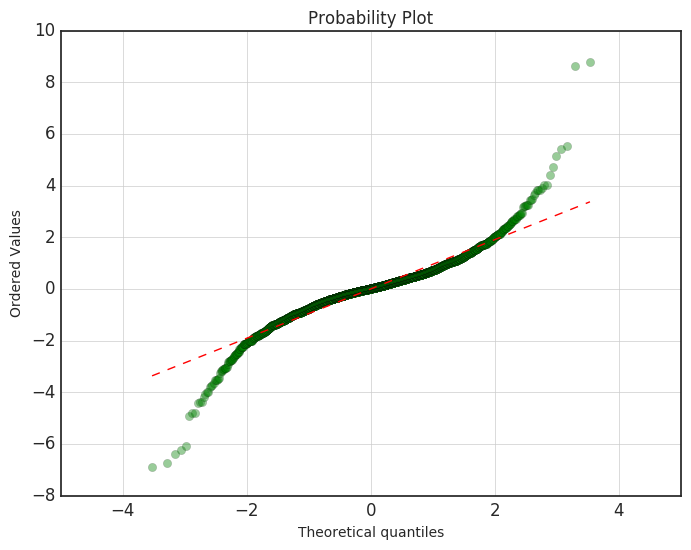

In [9]:
from scipy import stats
res = (x-mu)/sigma 
sres = np.sort(res,axis=None)
fig = figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
rc('xtick',labelsize=12);rc('ytick',labelsize=12);rc('legend',fontsize=12)
h = stats.probplot(res,plot=matplotlib.pyplot)
grid();
h1=ax.get_children()
h1[0].set(markerfacecolor='green',markeredgecolor='black',markeredgewidth=0.2,markersize=6,alpha=0.4)
h1[1].set(color='red',linestyle='--')
xlim(-5,5)
savefig("Images/"+Symbol+"QQPlot.pdf")
savefig("Images/"+Symbol+"QQPlot.eps")
show(fig)

It will be quite difficult to find time series that behave convincingly like stationary geometric Brownian motions. Most of the time the tests below will reject the normality of the standardized log returns.

In [10]:
#res = np.random.normal(0,1,10000);sres = np.sort(res,axis=None) # uncomment this to see numbers that pass the tests!
print('The Jarque-Bera statistic is %f, with p-value %g' % stats.jarque_bera(sres))
if len(res)<5000: # apparently this test is inaccurate for longer samples
    print('The Shapiro-Wilk statistic is %f, with p-value %g' % stats.shapiro(sres))
print('The Kolmogorov-Smirnov statistic is %f, with p-value %g' % stats.kstest(sres,'norm'))
ad = stats.anderson(res,dist='norm') # for some reason, sometimes ends up dividing by zero
# the Anderson-Darling test provides a list of levels and corresponding significances
i = find(ad[0]>ad[1]); 
if any(i): 
    i = argmax(i)
    print('According to the Anderson-Darling test, normality can be rejected at the %d%% significance level.'%ad[2][i])
else:
    print('According to the Anderson-Darling test, normality cannot be rejected at the %d%% significance level.'%ad[2][0])

The Jarque-Bera statistic is 10681.204096, with p-value 0
The Shapiro-Wilk statistic is 0.909657, with p-value 8.98064e-41
The Kolmogorov-Smirnov statistic is 0.087241, with p-value 1.38466e-22
According to the Anderson-Darling test, normality can be rejected at the 1% significance level.


/opt/conda/lib/python3.5/site-packages/scipy/stats/morestats.py:1461: RuntimeWarning: divide by zero encountered in log
  A2 = -N - np.sum((2*i - 1.0) / N * (log(z) + log(1 - z[::-1])), axis=0)
